# tensorcircuit SDK for QCloud（221230 ver）

## import the package

``apis`` is temporarily as the entry point submodule for qcloud

In [1]:
import tensorcircuit as tc
from tensorcircuit.cloud import apis
import numpy as np

## setup the token

The users need an API token from tQuK to connect to the server and submit tasks, the token only need be set once and it is then written to the local computer

In [18]:
apis.set_token("wROld-1665558660551115293;8")
# only required running once for a given laptop

{'tencent::': 'wROld-1665558660551115293;8',
 'tencent::simulator:tc': 'wROld-1665558660551115293;8'}

## list providers/devices/properties

In [7]:
apis.list_providers()

[tencent, local]

In [8]:
apis.list_devices("tencent")

[tencent::20xmon,
 tencent::9gmon,
 tencent::simulator:aer,
 tencent::simulator:qx,
 tencent::simulator:tc,
 tencent::simulator:tcn1]

In [4]:
apis.list_properties(device="9gmon")

{'id': '9gmon',
 'type': 'CHIP',
 'qubits': 9,
 'state': 'on',
 'queue': 0,
 'langs': ['tQASM', 'eQASM'],
 'memo': 'tQLab 9Gmon',
 'usage': '9gmon?o=0 \nthe o(ptimized) to specify optimization level bits: both = 3 (bits 11) = gate decomposition = 2 (bit 10) | qubit mapping = 1 (bit 01)'}

In [6]:
apis.list_properties(device="simulator:tcn1")

{'id': 'simulator:tcn1',
 'alias': 'simulator:tc?noise',
 'state': '',
 'queue': 0}

## Task submit and the results

In [10]:
c = tc.Circuit(1)
c.H(0)

t = apis.submit_task(device="simulator:tc", circuit=c, shots=1024)
print(t.details())
t.results(blocked=True)

{'id': '2831cfb4-cdae-4b1d-8917-70d4a0fa4b72', 'queue': 'low', 'device': 'simulator:tc?o=3', 'state': 'pending', 'shots': 1024, 'at': 1672391326132532, 'ts': {'pending': 1672391326132532, 'scheduled': 1672391326129379}, 'md5': 'db493e15a6e8a68beed1815f760b45d0', 'source': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ncreg c[1];\nh q[0];', 'version': '1', 'lang': 'OPENQASM', 'prior': 1, 'optimization': {}}


{'0': 549, '1': 475}

In [11]:
t.status()

'completed'

In [12]:
t.get_device()

tencent::simulator:tc

In [13]:
# resubmit a job
t1 = t.resubmit()
print(t1.details())
t1.results(blocked=True)

{'id': '7e212512-8d10-4bb9-bd24-5cf036da41d2', 'queue': 'low', 'device': 'simulator:tc?o=3', 'qubits': 1, 'state': 'pending', 'shots': 1024, 'at': 1672391337185756, 'ts': {'completed': 1672391327686452, 'pending': 1672391337185756, 'scheduled': 1672391337178889}, 'md5': 'db493e15a6e8a68beed1815f760b45d0', 'runAt': 1672391326, 'runDur': 1036, 'source': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[1];\ncreg c[1];\nh q[0];', 'version': '1', 'lang': 'OPENQASM', 'prior': 1, 'result': {'0': 549, '1': 475}, 'optimization': {}, 'results': {'0': 549, '1': 475}}


{'0': 534, '1': 490}

## local provider enable quick debugging and testing

In [14]:
apis.set_provider("local")
# using tc simulator on local device: your own laptop is your server
apis.list_devices()

[local::testing]

In [15]:
c = tc.Circuit(2)
c.h(0)
c.cx(0, 1)

# exactly the same API as tQuK
t = apis.submit_task(circuit=c, device="testing", shots=8192)
t.results(blocked=True)

{'00': 4100, '11': 4092}

In [16]:
tl = apis.list_tasks()
tl

[local::testing~~0e061ad5-e721-402a-a649-8dd4eb520d80]

In [19]:
id_ = tl[0].__str__()
print(id_)
t = apis.get_task(id_)
t.details()

local::testing~~0e061ad5-e721-402a-a649-8dd4eb520d80


{'id': '0e061ad5-e721-402a-a649-8dd4eb520d80',
 'state': 'completed',
 'at': 1672391359398387.0,
 'shots': 8192,
 'device': 'testing',
 'results': {'00': 4100, '11': 4092}}

In [20]:
# back to tencent server by
apis.set_provider("tencent")

tencent

## GHZ on real device and readout mitigation

In [23]:
nqubit = 9
shots = 4096
c = tc.Circuit(nqubit)
c.H(8)
c.cnot(8, 4)
c.cnot(4, 0)
c.cnot(0, 2)
c.cnot(2, 6)

t = apis.submit_task(
    circuit=c, shots=shots, device="9gmon", enable_qos_qubit_mapping=False
)
raw_count = t.results(blocked=True)
# blocked = True will block the process until the result is returned
# the default behavior is blocked=False, where only one query is made and raise error when the task is incomplete

In [24]:
ReadoutMit = tc.results.readout_mitigation.ReadoutMit
mit = ReadoutMit("9gmon?o=0")
mit.cals_from_system(nqubit, shots, method="local")
miti_count = mit.apply_correction(raw_count, nqubit, "square")

In [25]:
raw_count = tc.results.counts.marginal_count(raw_count, [8, 4, 0, 2, 6])
miti_count = tc.results.counts.marginal_count(miti_count, [8, 4, 0, 2, 6])
# only keep the result for qubit 8, 4, 0, 2, 6 and in that order

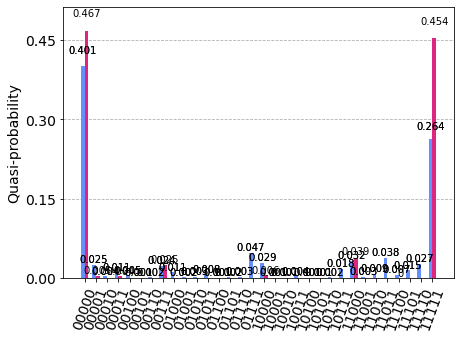

In [26]:
from qiskit.visualization import plot_histogram

plot_histogram([raw_count, miti_count])

In [27]:
ideal_count = tc.results.counts.vec2count(c.probability(), prune=True)
ideal_count = tc.results.counts.marginal_count(ideal_count, [8, 4, 0, 2, 6])
tc.results.counts.kl_divergence(
    ideal_count, raw_count
), tc.results.counts.kl_divergence(ideal_count, miti_count)

(0.4302675317947488, 0.08294928617219555)

In [28]:
# we can directly check local readout matrix on each qubit
print("readout matrix")
for i, m in enumerate(mit.single_qubit_cals):
    print("qubit %s:" % i)
    print(m)

readout matrix
qubit 0:
[[0.95800781 0.16650391]
 [0.04199219 0.83349609]]
qubit 1:
[[0.96606445 0.08862305]
 [0.03393555 0.91137695]]
qubit 2:
[[0.98266602 0.06079102]
 [0.01733398 0.93920898]]
qubit 3:
[[0.99389648 0.07177734]
 [0.00610352 0.92822266]]
qubit 4:
[[0.984375   0.06225586]
 [0.015625   0.93774414]]
qubit 5:
[[0.97802734 0.06787109]
 [0.02197266 0.93212891]]
qubit 6:
[[0.95703125 0.0925293 ]
 [0.04296875 0.9074707 ]]
qubit 7:
[[0.97607422 0.07910156]
 [0.02392578 0.92089844]]
qubit 8:
[[0.95629883 0.14672852]
 [0.04370117 0.85327148]]


In [19]:
# we can also do batch submission

c = tc.Circuit(2)
c.h(0)

c1 = tc.Circuit(2)
c1.h(1)

ts = apis.submit_task(device="9gmon", circuit=[c, c1], shots=1024)

for t in ts:
    print(t.results(blocked=True))

{'00': 526, '10': 481, '01': 10, '11': 7}
{'00': 524, '01': 470, '11': 18, '10': 12}


## three approaches for measure on partial of the qubits

Note the return order is not according to the original qubit order instead of measure order in the instructions

In [29]:
# directly partial measure

# approach 1
nqubit = 9
shots = 4096
c = tc.Circuit(nqubit)
c.H(8)
c.cnot(8, 4)
c.cnot(4, 0)
c.cnot(0, 2)
c.cnot(2, 6)

t = apis.submit_task(
    circuit=c, shots=shots, device="9gmon?o=0", measure=[8, 4, 0, 2, 6]
)
print(t.results(blocked=True))

{'00000': 1645, '11111': 988, '00101': 205, '11110': 147, '01111': 142, '11010': 137, '00001': 135, '11101': 101, '11011': 76, '01010': 70, '00010': 64, '10111': 58, '00100': 53, '01101': 36, '01000': 31, '10000': 29, '10101': 29, '00111': 23, '01011': 19, '11000': 18, '11100': 16, '01110': 15, '01100': 10, '10110': 9, '01001': 7, '10010': 7, '10001': 6, '10011': 6, '10100': 5, '11001': 5, '00011': 4}


In [21]:
# directly partial measure

# approach 2
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(9, 9)
qc.h(8)
qc.cnot(8, 4)
qc.cnot(4, 0)
qc.cnot(0, 2)
qc.cnot(2, 6)
qc.measure(8, 8)
qc.measure(4, 4)
qc.measure(0, 0)
qc.measure(2, 2)
qc.measure(6, 6)

t = apis.submit_task(circuit=qc, shots=shots, device="9gmon?o=0")
print(t.results(blocked=True))

{'00000': 3305, '11111': 2115, '00001': 378, '11110': 354, '11101': 296, '01111': 247, '00101': 212, '00010': 146, '11010': 145, '10111': 139, '11011': 135, '10101': 96, '00100': 86, '01010': 79, '01101': 71, '01000': 61, '11100': 54, '01110': 43, '10000': 28, '00111': 24, '01011': 24, '10110': 23, '00011': 22, '11001': 22, '10100': 15, '01100': 14, '11000': 14, '01001': 11, '10010': 10, '10001': 9, '10011': 8, '00110': 6}


 The above case also indicate that our ``submit_task`` API directly support Qiskit ``QuantumCircuit`` object

In [4]:
# directly partial measure

# approach 3

nqubit = 9
shots = 4096
c = tc.Circuit(nqubit)
c.H(8)
c.cnot(8, 4)
c.cnot(4, 0)
c.cnot(0, 2)
c.cnot(2, 6)
c.measure_instruction(8)
c.measure_instruction(4)
c.measure_instruction(0)
c.measure_instruction(2)
c.measure_instruction(6)

t = apis.submit_task(circuit=c, shots=shots, device="9gmon?o=0")
print(t.results(blocked=True))

{'00000': 1594, '11111': 984, '00101': 214, '11010': 167, '00001': 148, '11110': 125, '01111': 122, '11101': 120, '11011': 87, '10111': 74, '00010': 68, '00100': 44, '01000': 43, '01010': 39, '10101': 35, '01101': 32, '10000': 27, '00111': 23, '11000': 22, '11100': 18, '01110': 16, '10010': 15, '10110': 14, '01011': 10, '01100': 10, '01001': 9, '11001': 9, '00011': 8, '10011': 6, '10100': 6, '00110': 4, '10001': 3}


## two level compiling system

We provide compiling support at frond end (via tc-qiskit pipeline) and at back end (in qos)

In [5]:
# directly use built-in mitigation with expectation evaluation + front-end (tc/qiskit) compiling system

nqubit = 3
shots = 8192
c = tc.Circuit(nqubit)
c.h(0)
c.h(1)
c.rx(2, theta=0.7)
c.ry(1, theta=-1.2)
c.cnot(0, 1)
c.cnot(2, 0)
c.h(1)

print("exact: ", [np.real(c.expectation_ps(z=[i])) for i in range(nqubit)])
t = apis.submit_task(
    circuit=c,
    shots=shots,
    device="9gmon",
    compiled=True,
    enable_qos_qubit_mapping=False,
    enable_qos_gate_decomposition=False,
)

ct = t.results(blocked=True)

mit = tc.results.readout_mitigation.ReadoutMit("9gmon?o=0")
mit.cals_from_system(3, method="local")

print(
    "experiments (mitigated): ",
    [mit.expectation(ct, [i]) for i in range(nqubit)],
)

exact:  [array(-5.9604645e-08, dtype=float32), array(0.3623577, dtype=float32), array(0.76484215, dtype=float32)]
experiments (mitigated):  [0.04084053550245752, 0.28041151119143615, 0.8151639888461032]


In [6]:
c.draw()

┌───┐                    ┌───┐     
q_0: ───┤ H ├─────────────────■──┤ X ├─────
        ├───┤   ┌──────────┐┌─┴─┐└─┬─┘┌───┐
q_1: ───┤ H ├───┤ Ry(-1.2) ├┤ X ├──┼──┤ H ├
     ┌──┴───┴──┐└──────────┘└───┘  │  └───┘
q_2: ┤ Rx(0.7) ├───────────────────■───────
     └─────────┘                           
c: 3/══════════════════════════════════════

In [10]:
# use backend compiling system enabled by qos

nqubit = 3
shots = 8192
c = tc.Circuit(nqubit)
c.h(0)
c.h(1)
c.rx(2, theta=0.7)
c.ry(1, theta=-1.2)
c.cnot(0, 1)
c.cnot(2, 0)
c.h(1)

print("exact: ", [np.real(c.expectation_ps(z=[i])) for i in range(nqubit)])

t = apis.submit_task(
    circuit=c,
    shots=shots,
    device="9gmon",
    compiled=False,
    enable_qos_qubit_mapping=True,
    enable_qos_gate_decomposition=True,
)

ct = t.results(blocked=True)

mit = tc.results.readout_mitigation.ReadoutMit("9gmon")
mit.cals_from_system(3, method="local")

print(
    "experiments (mitigated): ",
    [mit.expectation(ct, [i]) for i in range(nqubit)],
)

exact:  [array(-5.9604645e-08, dtype=float32), array(0.3623577, dtype=float32), array(0.76484215, dtype=float32)]
experiments (mitigated):  [0.022390317700453997, 0.3906313645621186, 0.7582969721010189]


In [11]:
# inspect compiling results from the tc and qos for the task

t.get_compiled_details()

{'frontend': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[0];\nh q[1];\nrx(0.69999999) q[2];\nry(-1.2) q[1];\ncx q[0],q[1];\ncx q[2],q[0];\nh q[1];',
 'backend': {'progs': [{'code': 'Tencent Quantum Program\nversion 1.0\nqubit involved: q0,q1,q2,q3,q4,q5,q6,q7,q8\n# section: eqasm\n# section lines 33\neqasm program\nbs 1 H q0\nbs 0 H q1\nbs 0 RZB2 q2\nbs 1 S q2\nbs 0 S q1\nbs 1 H q2\nbs 0 H q1\nbs 1 RZB4 q2\nbs 0 RZB5 q2\nbs 0 RZB6 q2\nbs 0 RZB9 q2\nbs 0 RZB14 q2\nbs 0 RZB16 q2\nbs 0 RZB1 q1\nbs 0 RZB2 q1\nbs 0 RZB5 q1\nbs 0 RZB6 q1\nbs 0 RZB7 q1\nbs 0 RZB8 q1\nbs 0 RZB12 q1\nbs 0 RZB13 q1\nbs 0 RZB15 q1\nbs 0 RZB16 q1\nbs 1 H q2\nbs 0 H q1\nbs 1 SD q2\nbs 0 SD q1\nbs 1 RZB1 q2\nbs 0 RZB2 q2\nbs 0 CX (q0, q1)\nbs 1 H q1\nbs 0 CX (q2, q0)\nMEASZ q0,q1,q2\n# section: end\n',
    'lang': 'QEXE'}]}}

In [16]:
# dry run mode to query compiled circuit only from qos (not really sending the circuit to chips)

nqubit = 3
shots = 8192
c = tc.Circuit(nqubit)
c.h(0)
c.h(1)
c.rx(2, theta=0.7)
c.ry(1, theta=-1.2)
c.cnot(0, 1)
c.cnot(2, 0)
c.h(1)

print("exact: ", [np.real(c.expectation_ps(z=[i])) for i in range(nqubit)])

t = apis.submit_task(
    circuit=c,
    shots=shots,
    device="9gmon",
    compiled=True,
    enable_qos_qubit_mapping=True,
    enable_qos_gate_decomposition=True,
    qos_dry_run=True,
)

exact:  [array(-5.9604645e-08, dtype=float32), array(0.3623577, dtype=float32), array(0.76484215, dtype=float32)]


In [17]:
t.get_compiled_details()

{'frontend': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[0];\nh q[1];\nrz(-pi/2) q[1];\nh q[1];\nrz(-1.2) q[1];\nh q[1];\nrz(5*pi/2) q[1];\ncx q[0],q[1];\nh q[1];\nh q[2];\nrz(0.69999999) q[2];\nh q[2];\ncx q[2],q[0];',
 'backend': {'progs': [{'code': 'Tencent Quantum Program\nversion 1.0\nqubit involved: q0,q1,q2,q3,q4,q5,q6,q7,q8\n# section: eqasm\n# section lines 10\neqasm program\nbs 1 H q0\nbs 0 H q1\nbs 0 H q2\nbs 1 H q1\nbs 0 H q2\nbs 1 H q1\nbs 1 CX (q0, q1)\nbs 1 H q1\nbs 0 CX (q2, q0)\nMEASZ q0,q1,q2\n# section: end\n',
    'lang': 'QEXE'}]}}

## scalable readout simulation and mitigation

Via TensorCircuit, we provide the capability to do scalable (20+ qubits) readout error simulation and mitigation

In [8]:
# scalable readout error simulation on tQuK with tensorcircuit backend using tensor network approach

c = tc.Circuit(3)
t = apis.submit_task(circuit=c, device="simulator:tcn1", shots=8192)
t.results(blocked=True)

{'000': 7725, '001': 261, '100': 164, '010': 33, '101': 9}

In [9]:
t.results(mitigated=True)

{'000': 8192.0}

In [ ]:
c = tc.Circuit(25)
t = apis.submit_task(circuit=c, device="simulator:tcn1", shots=8192)
t.results(blocked=True)

In [14]:
# batch submission to the simulator
cs = []
for i in range(15):
    c = tc.Circuit(15)
    c.x(i)
    cs.append(c)
ts = apis.submit_task(circuit=cs, device="simulator:tcn1", shots=8192)

In [2]:
# mitigated with m3 scalable on count dict
c = tc.Circuit(15)
c.x(0)
t = apis.submit_task(circuit=c, device="simulator:tcn1", shots=8192)

mit = tc.results.readout_mitigation.ReadoutMit("simulator:tcn1")
mit.cals_from_system(15)

raw_count = t.results(blocked=True)
mit.apply_correction(raw_count, 15, method="M3_auto")

{'100000000000000': 8419.697440088592,
 '100100000000000': 70.62067781260015,
 '100000100000000': 32.06999431920804,
 '100000000000010': 21.05429511303664,
 '100000000100100': 12.737459534668831,
 '100000000010000': 6.717028675136155,
 '100000100000001': 5.517504244766566,
 '101000000000000': 5.343221628567916,
 '100000000000100': 5.316502711797031,
 '100101000000000': 5.055791656340502,
 '100000000100000': 4.583753814772621,
 '100000001010000': 4.563675472853387,
 '100100001000000': 4.200871093607515,
 '100000001000001': 4.037583611576253,
 '100000000100001': 3.993740071242359,
 '100000100000100': 3.620123993770483,
 '100100000000001': 3.331528047004301,
 '100000000000101': 2.9602206346214883,
 '110000000000100': 2.4447297020449055,
 '100100000000100': 2.1864507226578893,
 '100000101100000': 2.0581439661798693,
 '100000000000110': 1.6273556338878277,
 '110000001000000': 1.6165778033772777,
 '101000100000000': 1.5943040213903492,
 '100000100100000': 1.5109801589828913,
 '11000100000000

In [3]:
# mitigated with m3 scalable directly on expectation: not a wrapper for count but a new algorithm!
# see eq 6 in https://arxiv.org/pdf/2006.14044.pdf

mit.expectation(raw_count, [0])

-0.9987468671679187

## list task and get previous task

get history tasks

In [4]:
apis.list_tasks()

[tencent::9gmon?o=1~~0793030c-a3d0-426f-bf2c-0cb8ec4ad0b0,
 tencent::simulator:tcn1?o=3~~fdde7cb9-1738-4b82-becf-5add3bebdcc0,
 tencent::simulator:tcn1?o=3~~949ba88c-ba4f-44e1-b03b-e35873cc429e,
 tencent::simulator:tcn1?o=3~~a434a0d2-9d7e-46ff-ae42-e8397dd09cea,
 tencent::simulator:tcn1?o=3~~6462e2eb-cfb4-407a-bf93-12afe70ed73e,
 tencent::simulator:tcn1?o=3~~44bc1bba-628f-4739-9cf5-cc612059b635,
 tencent::simulator:tcn1?o=3~~67f33828-357e-49e8-a8f8-6ded2a16b5d3,
 tencent::simulator:tcn1?o=3~~e0e6660b-306d-494c-902b-630d656bc64d,
 tencent::simulator:tcn1?o=3~~13ac4aea-e6b7-469d-a67f-ad28a9dc16a0,
 tencent::simulator:tcn1?o=3~~dc53b3bf-48c5-43ee-a42c-8b140c14080d,
 tencent::simulator:tcn1?o=3~~53a949b9-a763-4cce-b11d-1d83b65095b3,
 tencent::simulator:tcn1?o=3~~7fdb1e4c-801a-4236-8ec8-be61101ff499,
 tencent::simulator:tcn1?o=3~~e7819297-e989-4620-840a-b15a6f988a1a,
 tencent::simulator:tcn1?o=3~~29ca9ff7-1063-4477-b827-e2e11613ef46,
 tencent::simulator:tcn1?o=3~~aa05e4e2-72fb-4b0b-969e-56c

In [5]:
apis.list_tasks(device="9gmon")

[tencent::9gmon?o=1~~0793030c-a3d0-426f-bf2c-0cb8ec4ad0b0,
 tencent::9gmon?o=0~~5d2d8e11-760e-4f88-b003-5b5901edbf21,
 tencent::9gmon?o=0~~8e3a77f7-838e-4d08-a75a-b864704b89e3,
 tencent::9gmon?o=0~~e3c137fc-e478-48f6-bc89-c077c1a3cd9e,
 tencent::9gmon?o=0~~7a251212-f21d-46f1-976d-9a5ba066bb40,
 tencent::9gmon?o=0~~6445a6bf-9cf8-4b7d-af6f-aeeb5f4989ef,
 tencent::9gmon?o=0~~91be022d-afd5-414e-8776-88acb6f1d3dd,
 tencent::9gmon?o=0~~f962fbd8-dffc-4369-b2e6-696c3db561ed,
 tencent::9gmon?o=0~~26dc60ad-f9c1-4d82-bd87-266c8520bd90,
 tencent::9gmon?o=0~~d841bb5b-5549-488c-b660-47f59e129a7b,
 tencent::9gmon?o=2~~315fb708-c9da-4a53-b2ac-c206e563620b,
 tencent::9gmon?o=0~~198b0d28-1c9b-400c-aecc-af926d789c1e,
 tencent::9gmon~~27562978-1588-4314-8517-782fd7b27265,
 tencent::9gmon~~bcc06a7a-350d-4b6a-b536-829eca1cf07f,
 tencent::9gmon~~b0a0c0ab-d902-457c-97c8-0a731d0982d8,
 tencent::9gmon~~c64a78d3-54c8-40f1-b64f-f7027890368b,
 tencent::9gmon?o=3~~ebceb01d-9902-4879-b4c1-be39c2dd0053,
 tencent::9gm

In [6]:
t = apis.get_task("d77bec2f-ab07-4dbc-a273-caa8b23a921c")

In [7]:
t.details()

{'id': 'd77bec2f-ab07-4dbc-a273-caa8b23a921c',
 'queue': 'txqlab',
 'device': '9gmon',
 'state': 'completed',
 'shots': 4096,
 'at': 1670549560020389,
 'ts': {'completed': 1670549560020389,
  'pending': 1670549557999879,
  'scheduled': 1670549557997345},
 'md5': '4a2e4269b3a3e78e0f6509ba78d9bdd8',
 'runAt': 1670549557,
 'runDur': 2000,
 'source': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[0];\nrz(-pi/2) q[1];\nh q[1];\ncx q[0],q[1];\nrz(-1.4) q[1];\ncx q[0],q[1];\nrz(-1.4) q[1];\nh q[1];\nrz(5*pi/2) q[1];\nh q[1];\nrz(-pi/2) q[2];\nh q[2];\ncx q[0],q[2];\nrz(1.4) q[2];\ncx q[0],q[2];\nrz(-1.4) q[2];\nh q[2];\nrz(5*pi/2) q[2];\nh q[2];',
 'version': '1',
 'lang': 'OPENQASM',
 'prior': 1,
 'result': {'000': 492,
  '001': 599,
  '010': 589,
  '011': 685,
  '100': 255,
  '101': 518,
  '110': 363,
  '111': 595},
 'optimization': {},
 'results': {'000': 492,
  '001': 599,
  '010': 589,
  '011': 685,
  '100': 255,
  '101': 518,
  '110': 363,
  '111': 595}}

In [8]:
t = apis.get_task("tencent::9gmon~~e32bb488-5ee9-4b07-8217-1e78ceb4bde3")

In [9]:
t.details()

{'id': 'e32bb488-5ee9-4b07-8217-1e78ceb4bde3',
 'queue': 'txq.low',
 'device': '9gmon',
 'state': 'completed',
 'shots': 8192,
 'at': 1671158467283362,
 'ts': {'completed': 1671158467283362,
  'pending': 1671158406209032,
  'scheduled': 1671158406206228},
 'md5': 'e2b1202e83341de33b19b9acce1e795d',
 'runAt': 1671158405,
 'runDur': 61000,
 'source': 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nx q[0];\nx q[1];\nx q[2];',
 'version': '1',
 'lang': 'OPENQASM',
 'prior': 1,
 'result': {'000': 8,
  '001': 39,
  '010': 28,
  '011': 367,
  '100': 41,
  '101': 493,
  '110': 530,
  '111': 6686},
 'optimization': {},
 'results': {'000': 8,
  '001': 39,
  '010': 28,
  '011': 367,
  '100': 41,
  '101': 493,
  '110': 530,
  '111': 6686}}